In [1]:
# Some setup
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

'''
Function for visualizing images: Given a tensor of images, number of images, and
size per image, plots and prints the images in an uniform grid.
'''
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of the DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector, 
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating a noise vector: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
    n_samples: the number of samples in the batch, a scalar
    z_dim: the dimension of the noise vector, a scalar
    device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white (1 channel), so that's our default.
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the Discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
        image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [4]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# We tranform our image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# We initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.6948393950462336, discriminator loss: 0.6963248128890994


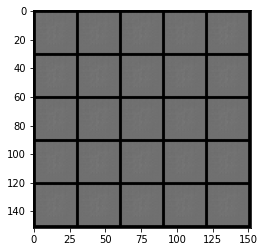

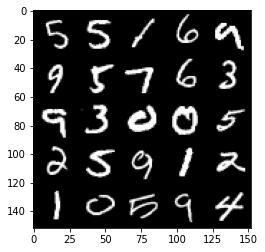

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 0.6931503944396968, discriminator loss: 0.6932220647335056


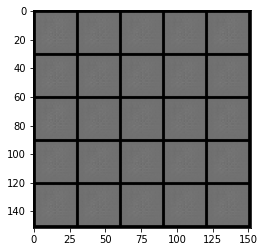

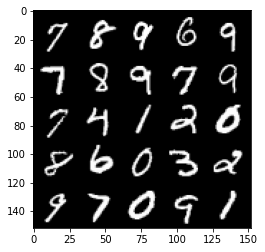

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 0.693458396434784, discriminator loss: 0.6932327823638915


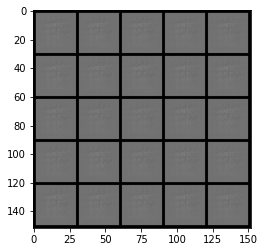

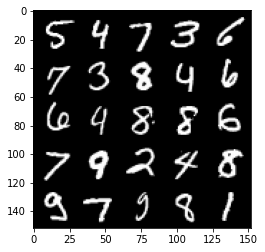

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 0.6935751254558563, discriminator loss: 0.6931953687667848


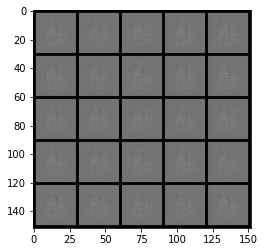

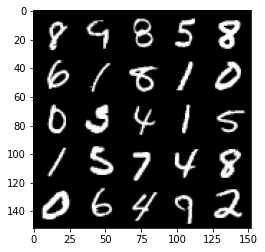

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.6933520987033848, discriminator loss: 0.6932111035585399


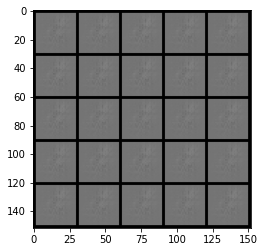

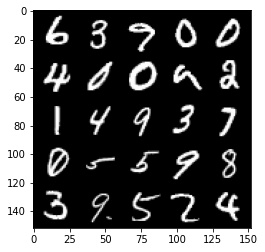

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.6933172216415405, discriminator loss: 0.6931861521005633


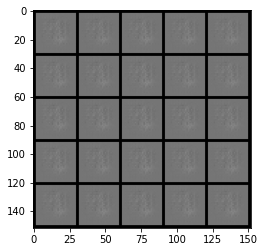

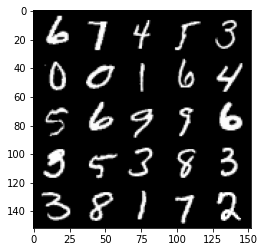

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.6934460389614108, discriminator loss: 0.6931827667951579


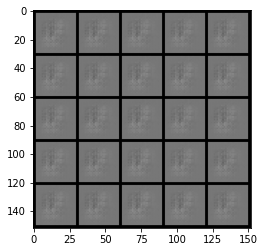

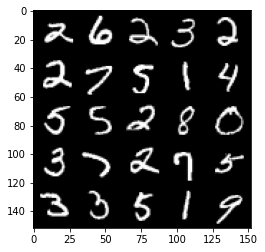

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.693244964718818, discriminator loss: 0.6931740095615394


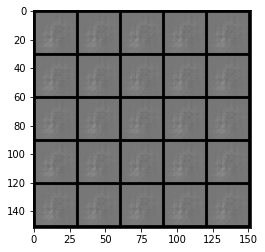

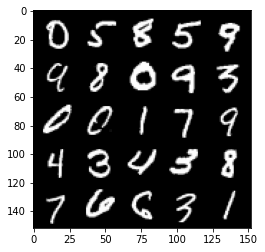

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.6933501031398775, discriminator loss: 0.693174562096596


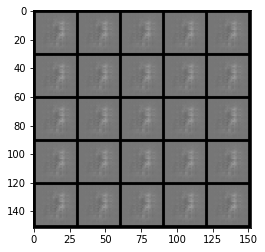

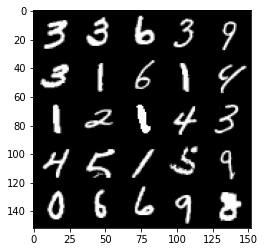

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.6933896251916887, discriminator loss: 0.6931944670677178


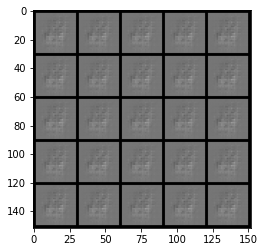

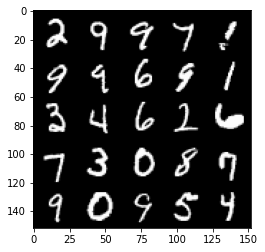

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.6934671106338499, discriminator loss: 0.6932111120224


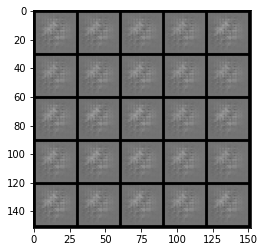

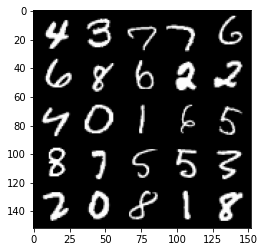

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.6935021306276319, discriminator loss: 0.6931806234121318


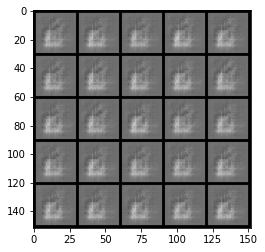

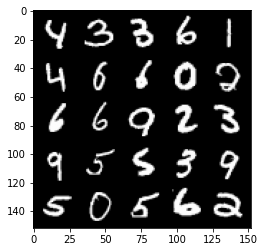

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.6954219467639924, discriminator loss: 0.6924621037244798


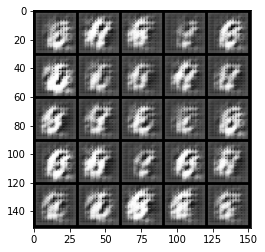

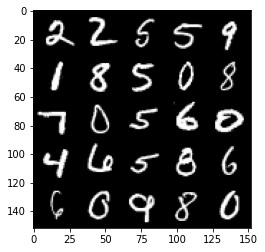

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.7001345306634897, discriminator loss: 0.6916039958000182


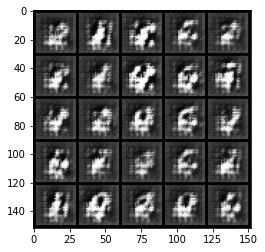

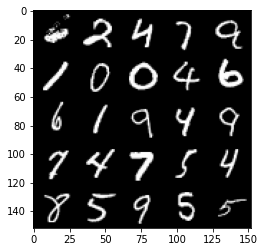

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.69924398624897, discriminator loss: 0.6903603470325468


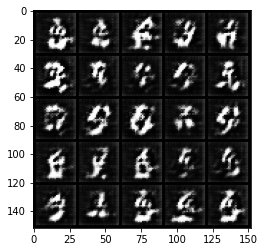

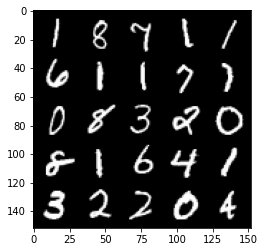

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7014313379526135, discriminator loss: 0.6890955957174301


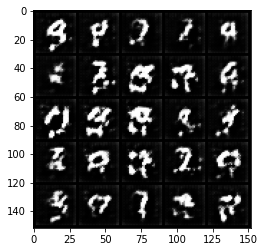

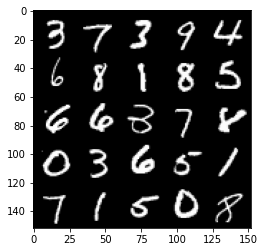

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7033824981451038, discriminator loss: 0.6884631102085114


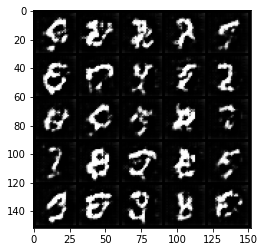

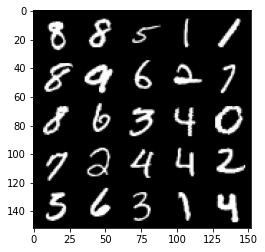

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7042877382040026, discriminator loss: 0.6875304383039471


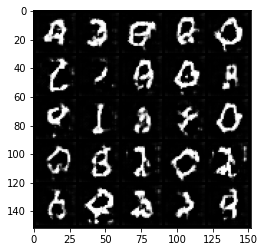

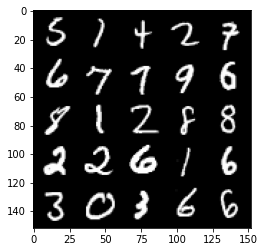

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7022354937791819, discriminator loss: 0.6886032899618142


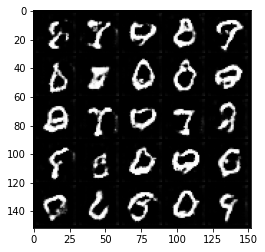

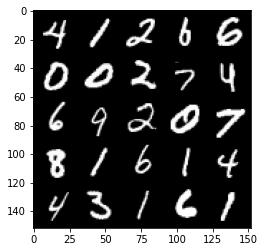

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.7035979661941527, discriminator loss: 0.6890426236391073


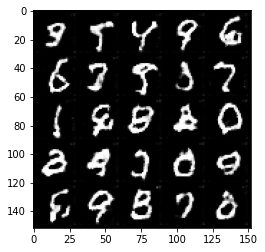

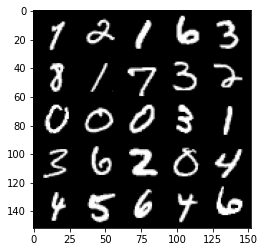

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.7020283613204958, discriminator loss: 0.6894115660190576


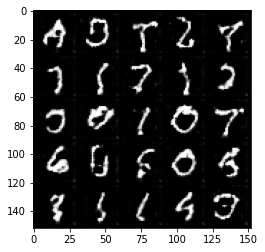

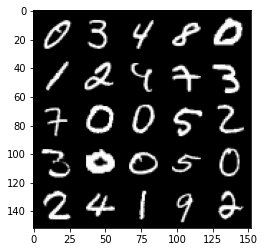

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.7006069880723954, discriminator loss: 0.6902512346506114


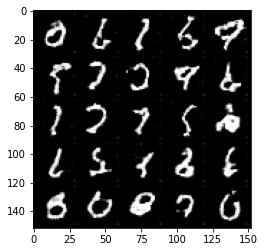

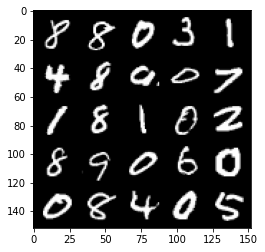

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.6995345780849459, discriminator loss: 0.6904472204446797


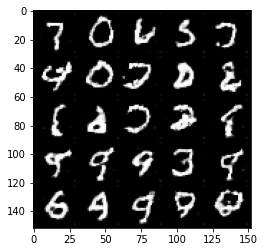

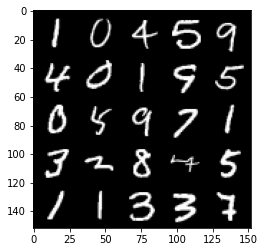

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.6990169621706014, discriminator loss: 0.6913714429140092


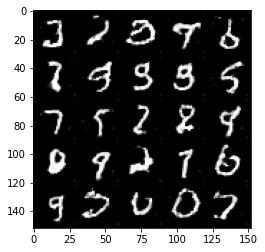

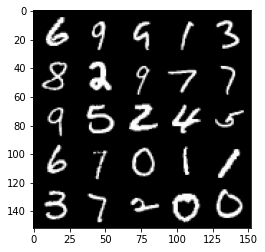

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.6979312603473663, discriminator loss: 0.6915377459526054


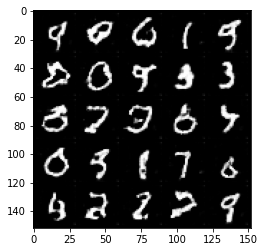

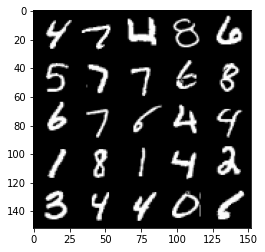

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.6974830292463304, discriminator loss: 0.6918113961219784


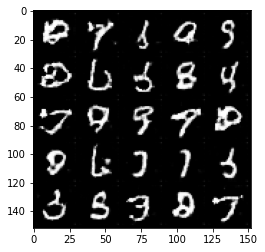

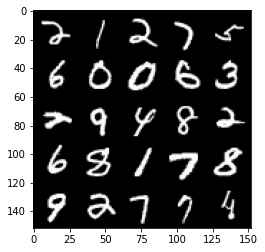

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.6970583912134171, discriminator loss: 0.6918223929405216


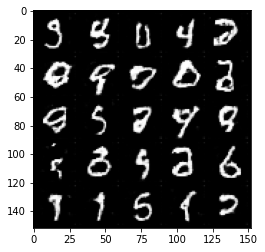

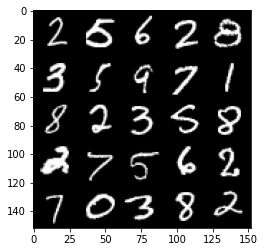

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.6971053221225738, discriminator loss: 0.6921608853340152


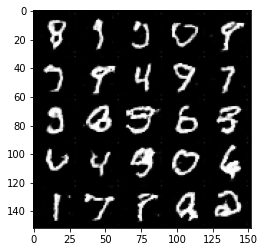

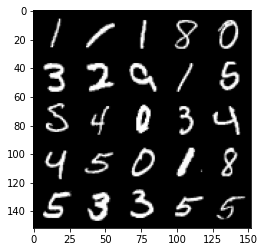

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.6969650609493269, discriminator loss: 0.6925932894945142


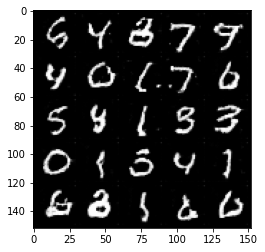

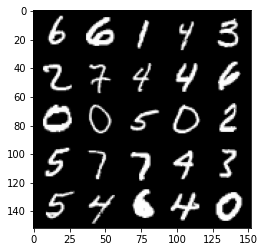

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.6959801785945893, discriminator loss: 0.692883563995361


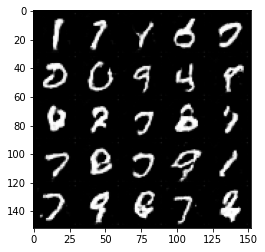

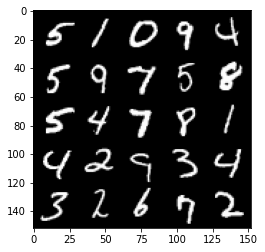

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.6955651705265048, discriminator loss: 0.6928652981519698


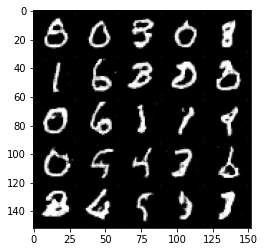

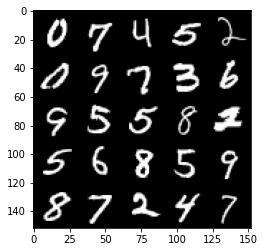

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.6956176218986517, discriminator loss: 0.6930803928375247


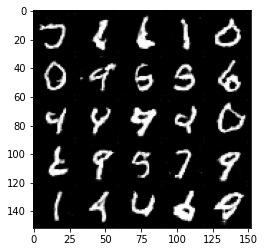

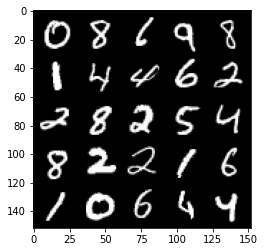

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.6965860685110092, discriminator loss: 0.6931843473911284


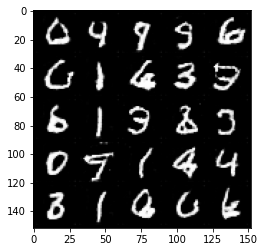

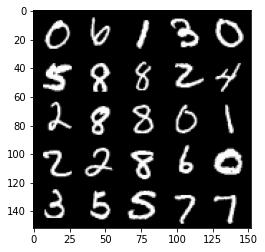

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.6950169647932052, discriminator loss: 0.693238873124123


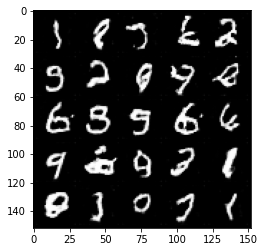

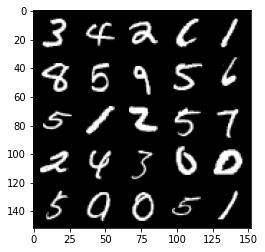

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.6954019718170175, discriminator loss: 0.6935108879804606


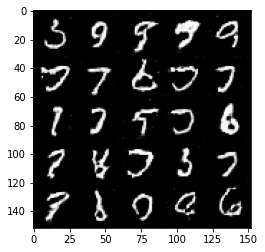

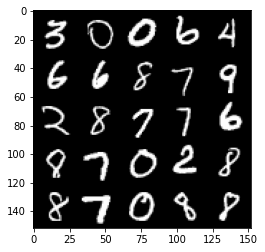

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.6947388346195225, discriminator loss: 0.6935555114746097


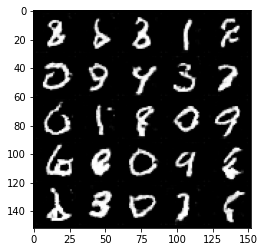

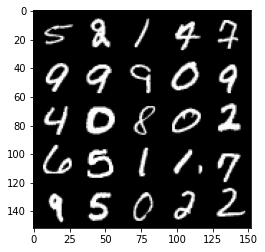

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.6948101106882094, discriminator loss: 0.6937077888250351


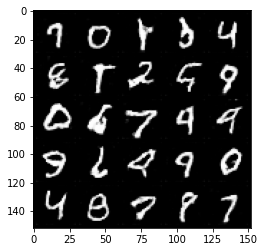

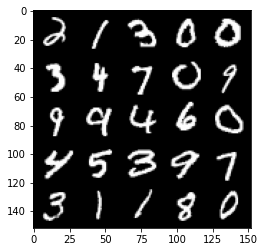

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.6945826150178902, discriminator loss: 0.693673849105835


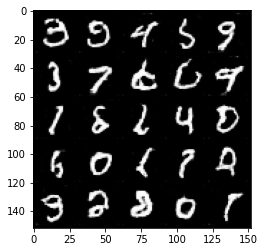

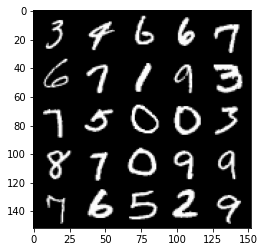

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.6945631371736521, discriminator loss: 0.6937974039316175


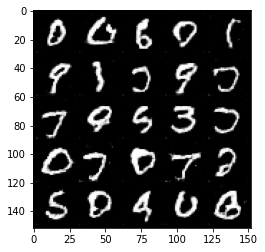

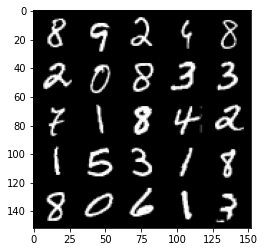

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.694267763376236, discriminator loss: 0.693762042164803


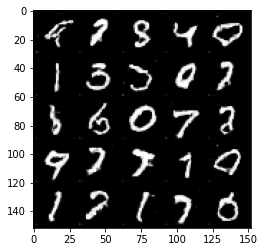

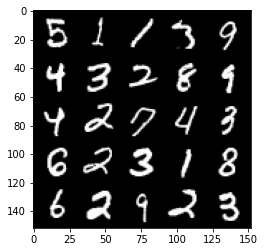

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.6944816551208494, discriminator loss: 0.6936831959486008


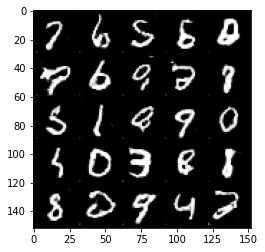

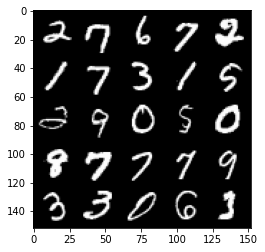

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.6939134520292285, discriminator loss: 0.6936875295639042


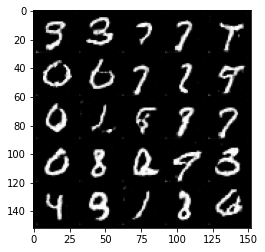

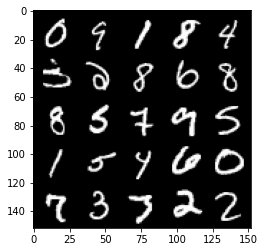

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.6943660717010499, discriminator loss: 0.6936607860326771


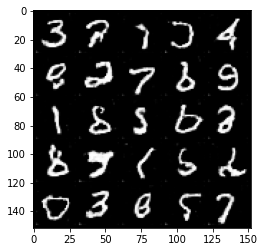

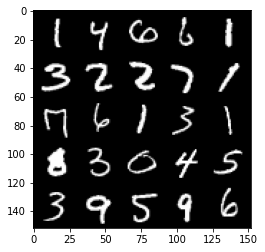

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.6937487144470219, discriminator loss: 0.6936017446517944


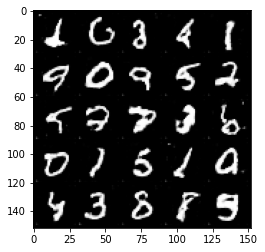

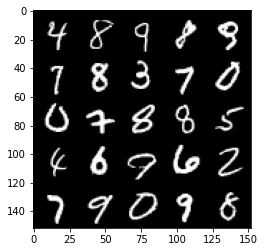

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.6939095827341076, discriminator loss: 0.6936828365325929


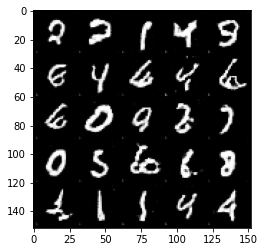

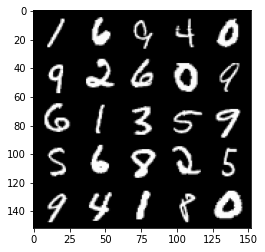

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.694050228357315, discriminator loss: 0.693655600905419


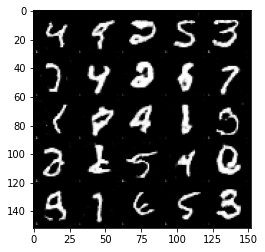

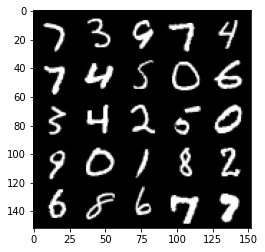

In [6]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update Discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update Generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1